<a href="https://colab.research.google.com/github/pradanaadn/trash-detection/blob/main/notebook/experiment_trash_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets huggingface_hub transformers wandb torchmetrics loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Dataset Loading

In [2]:
RANDOM_SEED = 161224

In [38]:
from collections import Counter
import numpy as np
import wandb
import os
from pathlib import Path
import matplotlib.pyplot as plt
import random
from huggingface_hub import login as hf_login, create_branch
from huggingface_hub import PyTorchModelHubMixin
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm
from loguru import logger

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torchvision.models import mobilenet_v3_large
from torchmetrics.classification import (MulticlassAccuracy,
                                         MulticlassPrecision,
                                         MulticlassRecall,
                                         MulticlassF1Score)
from torchmetrics.aggregation import MeanMetric
from torchsummary import summary





In [4]:
datasets = load_dataset("garythung/trashnet", split = 'train')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [5]:
datasets

Dataset({
    features: ['image', 'label'],
    num_rows: 5054
})

### Dataset Label

In [6]:
label = datasets.features['label'].names
label

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [7]:
int2str_label = [label[x] for x in datasets['label']]



In [8]:
counts = Counter(int2str_label)
counts.most_common()

[('paper', 1188),
 ('glass', 1002),
 ('plastic', 964),
 ('metal', 820),
 ('cardboard', 806),
 ('trash', 274)]

In [9]:
list(map(lambda x: (x[0], f"{(x[1]/datasets.num_rows)*100:.3} %"), counts.most_common()))

[('paper', '23.5 %'),
 ('glass', '19.8 %'),
 ('plastic', '19.1 %'),
 ('metal', '16.2 %'),
 ('cardboard', '15.9 %'),
 ('trash', '5.42 %')]

It's look like the  datasat is class imbalance

### Dataset Distribution

In [ ]:
datasets[0:10]

{'image': [<PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.Image.Image image mode=RGB size=4032x3024>],
 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
datasets[1000:1010]

{'image': [<PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.Image.Image image mode=RGB size=2448x3264>,
  <PIL.Image.Image image mode=RGB size=2448x3264>,
  <PIL.Image.Image image mode=RGB size=3264x2448>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=3264x2448>,
  <PIL.Image.Image image mode=RGB size=3264x2448>,
  <PIL.Image.Image image mode=RGB size=3264x2448>,
  <PIL.Image.Image image mode=RGB size=3264x2448>,
  <PIL.Image.Image image mode=RGB size=2448x3264>],
 'label': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]}

In [ ]:
datasets[2000:2010]

{'image': [<PIL.Image.Image image mode=RGB size=3264x2448>,
  <PIL.Image.Image image mode=RGB size=2448x3264>,
  <PIL.Image.Image image mode=RGB size=2448x3264>,
  <PIL.Image.Image image mode=RGB size=2448x3264>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=2448x3264>,
  <PIL.Image.Image image mode=RGB size=2448x3264>,
  <PIL.Image.Image image mode=RGB size=2448x3264>,
  <PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.Image.Image image mode=RGB size=4032x3024>],
 'label': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]}

In [ ]:
datasets[-10:-1]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>],
 'label': [5, 5, 5, 5, 5, 5, 5, 5, 5]}

from above, we can see that the datasets are ordered by label. We will shuffle the dataset. It will make the model more generalized the data. The image size are also  varying.

### Shuffle Dataset

In [10]:
dataset_shuffle = datasets.shuffle(seed=RANDOM_SEED)

In [ ]:
dataset_shuffle[0:10]

{'image': [<PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.Image.Image image mode=RGB size=3264x2448>,
  <PIL.Image.Image image mode=RGB size=4032x3024>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.Image.Image image mode=RGB size=3024x4032>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x384>],
 'label': [0, 2, 1, 0, 3, 0, 3, 3, 4, 0]}

### Dataset Vizualisation

In [ ]:
def vizualize_random_dataset():
    new_size = (224, 224)
    random_dataset = random.choices(dataset_shuffle, k=10)
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for index, dataset in enumerate(random_dataset):
      row = index // 5
      col = index % 5
      axes[row, col].imshow(dataset['image'].resize(new_size))
      axes[row, col].set_title(f"Label: {label[dataset['label']]}")
      axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

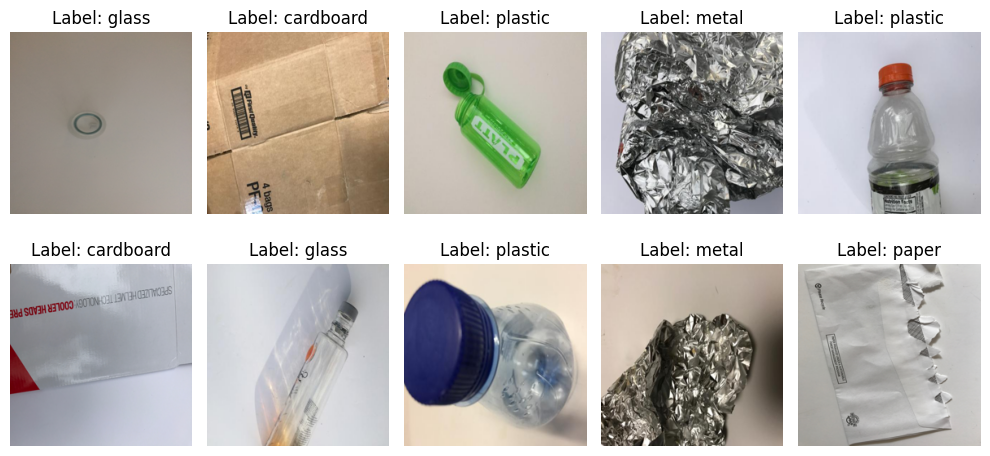

In [ ]:
vizualize_random_dataset()

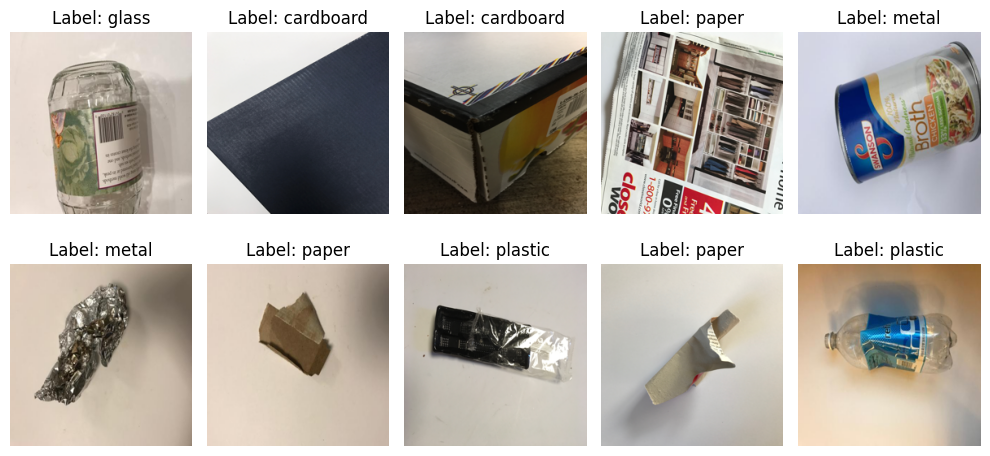

In [ ]:
vizualize_random_dataset()

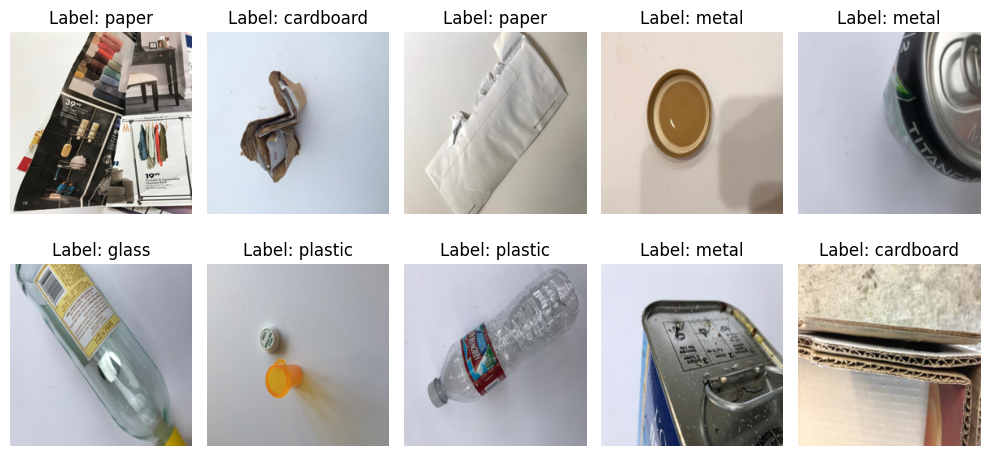

In [ ]:
vizualize_random_dataset()

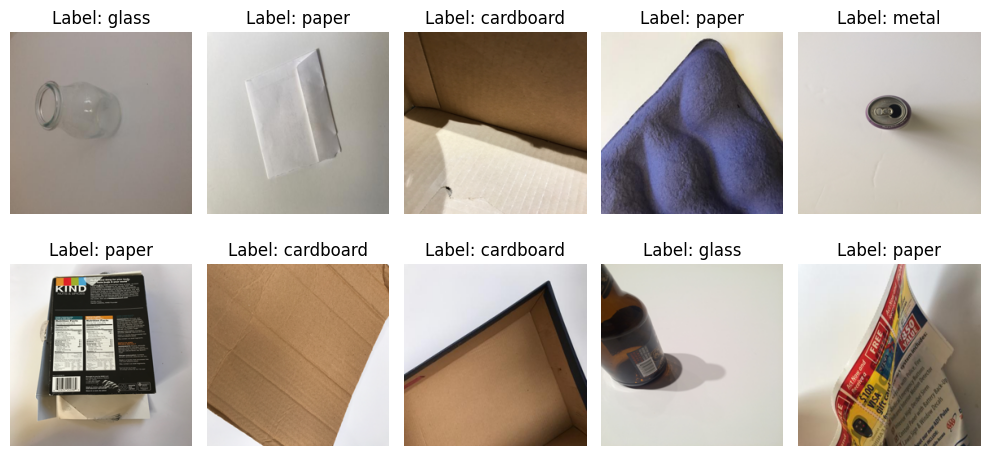

In [ ]:
vizualize_random_dataset()

In [ ]:
vizualize_random_dataset()

We rarely see data with label trash, so we will vizualize it using the before shuffle dataset to get the data with label 5

In [ ]:
trash_dataset = [data for data in zip(datasets[-100:-1]['image'],datasets[-100:-1]['label'] )]
def vizualize_trash_dataset():
    new_size = (224, 224)
    random_dataset = random.choices(trash_dataset, k=10)
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for index, dataset in enumerate(random_dataset):
      row = index // 5
      col = index % 5
      axes[row, col].imshow(dataset[0].resize(new_size))
      axes[row, col].set_title(f"Label: {label[dataset[1]]}")
      axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

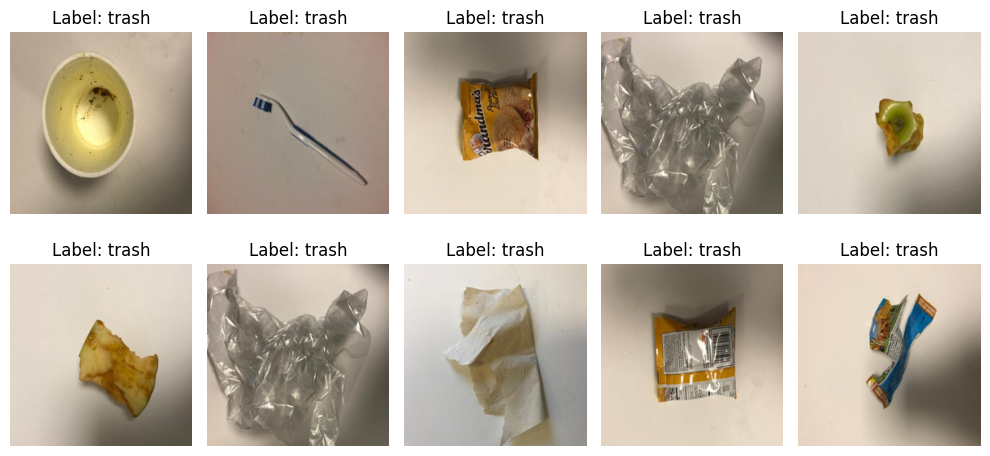

In [ ]:
vizualize_trash_dataset()

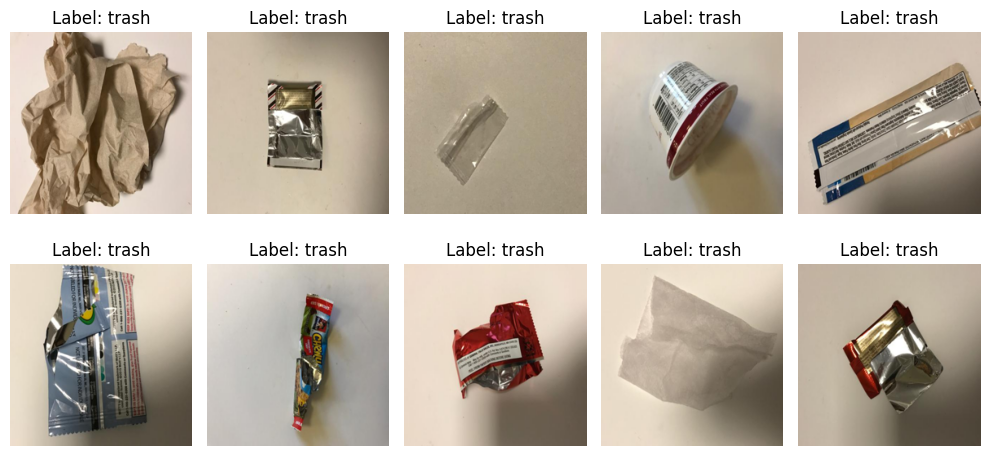

In [ ]:
vizualize_trash_dataset()

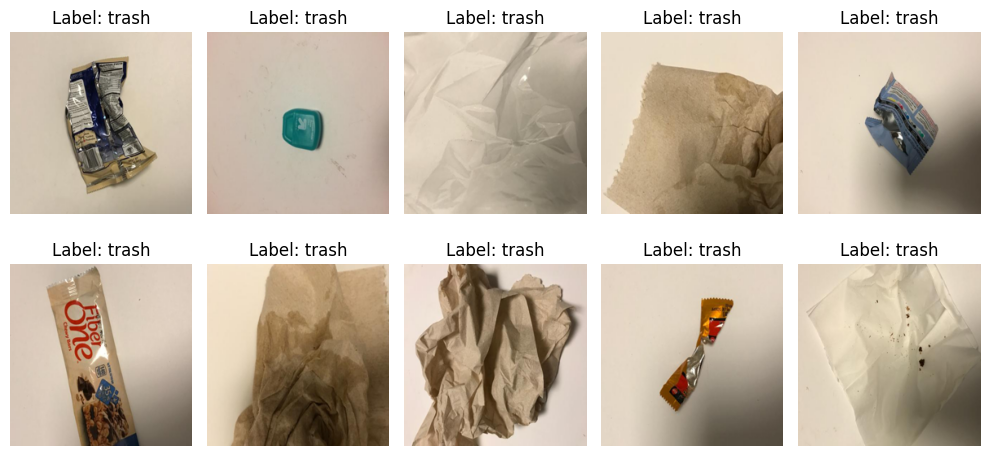

In [ ]:
vizualize_trash_dataset()

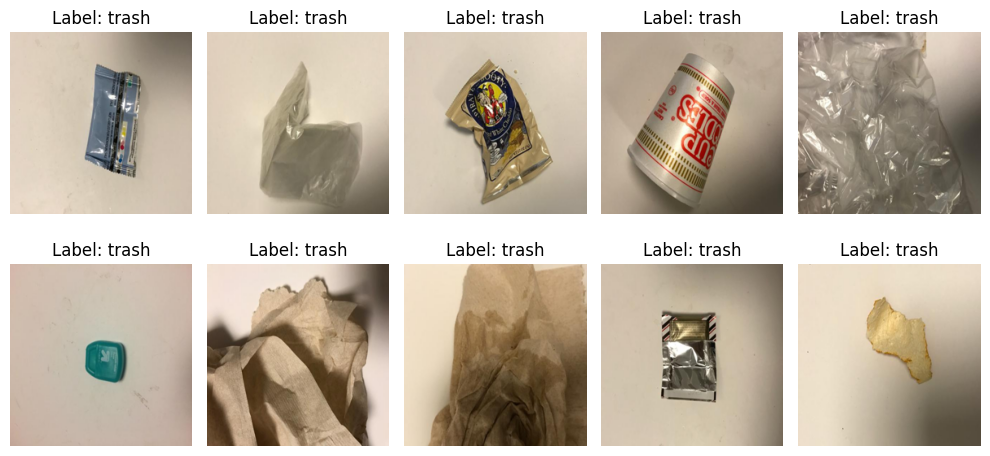

In [ ]:
vizualize_trash_dataset()

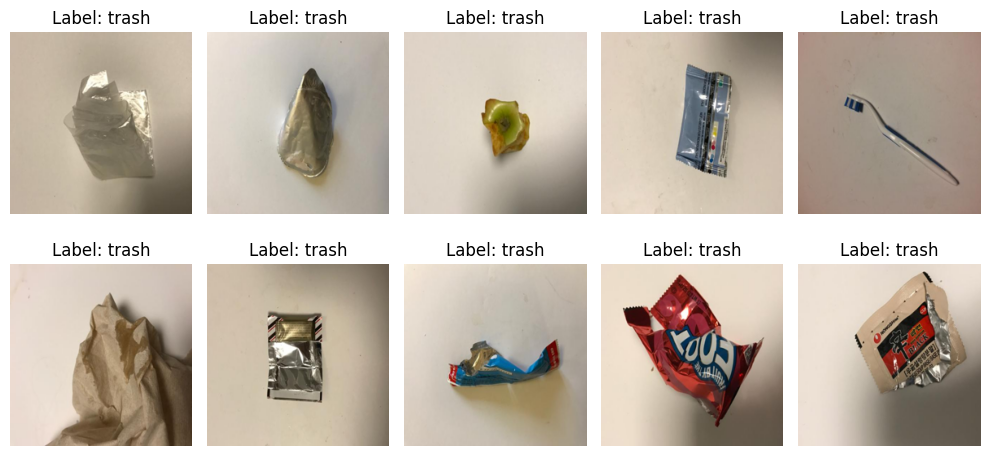

In [ ]:
vizualize_trash_dataset()

#### Trash Label Definition

Hmm, image with label trash is little bit confusing to define. After some research, I found the [dataset creator project report](https://cs229.stanford.edu/proj2016/report/ThungYang-ClassificationOfTrashForRecyclabilityStatus-report.pdf). So, trash is define as waste that can't be recycle. But, I think it will impact the model performence, because the trash image is not consistent with the other label (mislabeled). The dataset creator also omit trash label. But we will try to adress the class imbalance with several technique.

## Image Preprocessing


In [11]:
image_size = (224,224)
transform_train = v2.Compose([
    v2.Resize(size=image_size),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
])

transform_val = v2.Compose([
    v2.Resize(size=image_size),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [12]:
data = dataset_shuffle.train_test_split(test_size=0.2, seed=RANDOM_SEED)
data_train = data['train']
data_test_val = data['test']

In [13]:
data_val_test = data_test_val.train_test_split(test_size=0.5, seed=RANDOM_SEED)
data_val_test

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 505
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 506
    })
})

In [14]:
data_val = data_val_test['train']
data_test = data_val_test['test']

In [15]:
data_train, data_val, data_test

(Dataset({
     features: ['image', 'label'],
     num_rows: 4043
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 505
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 506
 }))

In [16]:
data_train_transform = data_train.with_transform(transform_train)
data_val_transform = data_val.with_transform(transform_val)
data_test_transform = data_test.with_transform(transform_val)

In [ ]:
def vizualize_random_dataset(datasets):

    random_dataset = random.choices(datasets, k=10)
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for index, dataset in enumerate(random_dataset):
      row = index // 5
      col = index % 5

      image_np = np.array(dataset['image'])
      image_np = np.transpose(image_np, (1, 2, 0))
      image = Image.fromarray((image_np * 255).astype('uint8'))
      axes[row, col].imshow(image)
      axes[row, col].set_title(f"Label: {label[dataset['label']]}")
      axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
vizualize_random_dataset(data_train_transform)

In [ ]:
def vizualize_fix_dataset(datasets):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    dataset_image = datasets['image']
    dataset_label = datasets['label']
    for index, dataset in enumerate(zip(dataset_image,dataset_label )):
      row = index // 5
      col = index % 5

      image_np = np.array(dataset[0])
      image_np = np.transpose(image_np, (1, 2, 0))
      image = Image.fromarray((image_np * 255).astype('uint8'))
      axes[row, col].imshow(image)
      axes[row, col].set_title(f"Label: {label[dataset[1]]}")
      axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
first_ten_train_data = data_train_transform[0:10]
vizualize_fix_dataset(first_ten_train_data)

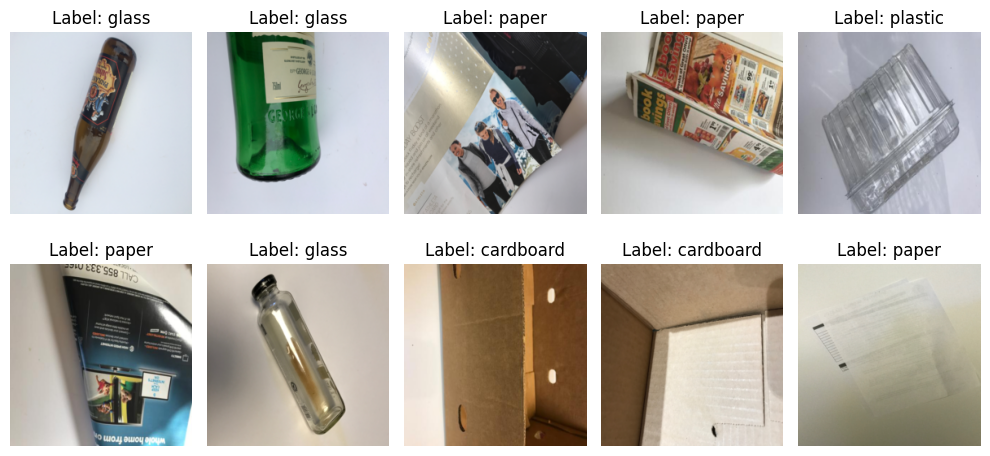

In [ ]:
first_ten_train_data = data_train_transform[0:10]
vizualize_fix_dataset(first_ten_train_data)

In [ ]:
first_ten_val_data = data_val_transform[0:10]
vizualize_fix_dataset(first_ten_val_data)

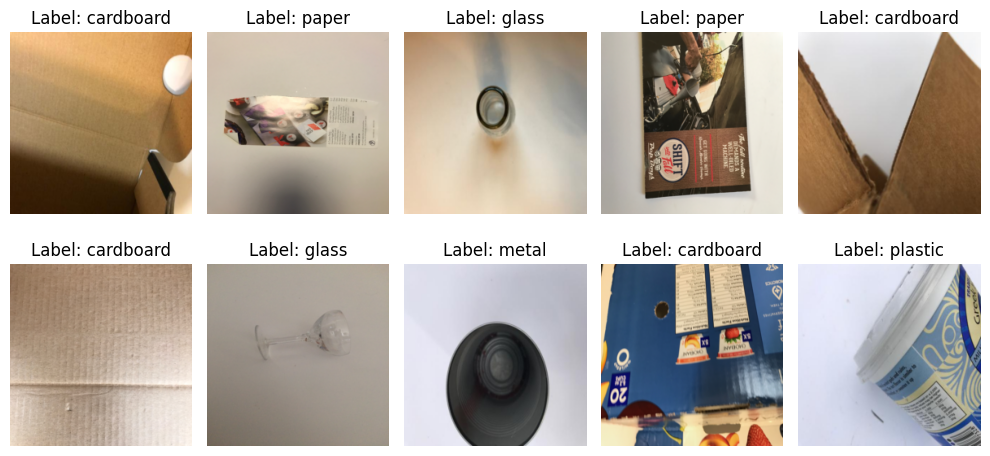

In [ ]:
vizualize_fix_dataset(first_ten_val_data)

In [ ]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name, i)

Tesla T4 0


## Modeling

### Wandb and HuggingFace Initialization

In [17]:
from google.colab import userdata


In [18]:
wandb.login(key=userdata.get('WANDB_TOKEN'), relogin=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [19]:
hf_login(token = userdata.get('HF_TOKEN'))

Next we will build the model. For the first architecture, We will use the CNN model from Dataset Creator Report.

In [ ]:
class TrashNet(nn.Module, PyTorchModelHubMixin):
    def __init__(self, num_classes=6):
        super(TrashNet, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 192, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 288, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(288),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(288, 288, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(288),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(288, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6912, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        # print(f"Initial Shape : {x.shape}")
        out = self.layer1(x)
        # print(f"Layer {1} Shape : {out.shape}")
        out = self.layer2(out)
        # print(f"Layer {2} Shape : {out.shape}")
        out = self.layer3(out)
        # print(f"Layer {3} Shape : {out.shape}")
        out = self.layer4(out)
        # print(f"Layer {4} Shape : {out.shape}")
        out = self.layer5(out)
        # print(f"Layer {5} Shape : {out.shape}")
        out = out.reshape(out.size(0), -1)
        # print(f"Layer {6} Shape : {out.shape}")
        out = self.fc(out)
        # print(f"Layer {7} Shape : {out.shape}")
        out = self.fc1(out)
        # print(f"Layer {8} Shape : {out.shape}")
        out = self.fc2(out)
        # print(f"Layer {9} Shape : {out.shape}")
        return out

model = TrashNet().to(runs.config.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=runs.config.learning_rate)

In [ ]:
batch = next(iter(dl_train))
batch['image'].shape

torch.Size([64, 3, 224, 224])

In [ ]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 192, 27, 27]         460,992
       BatchNorm2d-6          [-1, 192, 27, 27]             384
              ReLU-7          [-1, 192, 27, 27]               0
         MaxPool2d-8          [-1, 192, 13, 13]               0
            Conv2d-9          [-1, 288, 13, 13]         497,952
      BatchNorm2d-10          [-1, 288, 13, 13]             576
             ReLU-11          [-1, 288, 13, 13]               0
           Conv2d-12          [-1, 288, 13, 13]         746,784
      BatchNorm2d-13          [-1, 288, 13, 13]             576
             ReLU-14          [-1, 288,

In [20]:
def create_metrics(num_classes, device , prefix_list = None):
    prefixs = prefix_list or ['train', 'val']
    metrics = {}
    for prefix in prefixs:
        for average in ['macro', 'micro', 'weighted']:
            metrics[f'{prefix}_accuracy_{average}'] = MulticlassAccuracy(
                num_classes=num_classes, average=average).to(device)
            metrics[f'{prefix}_precision_{average}'] = MulticlassPrecision(
                num_classes=num_classes, average=average).to(device)
            metrics[f'{prefix}_recall_{average}'] = MulticlassRecall(
                num_classes=num_classes, average=average).to(device)
            metrics[f'{prefix}_f1_{average}'] = MulticlassF1Score(
                num_classes=num_classes, average=average).to(device)
    return metrics

In [21]:
class EarlyStopping:
    def __init__(self,config, patience=7, min_delta=0, mode='min', save_path='checkpoints' ):
        self.patience = config.early_stopping_patience or patience
        self.min_delta =  min_delta
        self.mode = mode
        self.counter = 0
        self.config = config
        self.best_score = None
        self.early_stop = False
        self.save_path = Path(save_path)
        self.save_path.mkdir(parents=True, exist_ok=True)
        self.best_path = self.save_path / 'best_model.pth'
        self.min_delta *= 1 if mode == 'min' else -1

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        else:
            if self.mode == 'min':
                improvement = self.best_score - score > self.min_delta
            else:
                improvement = score - self.best_score > self.min_delta

            if improvement:
                self.best_score = score
                self.counter = 0
                self.save_checkpoint(model)
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

    def save_checkpoint(self, model):
        logger.info("Saving best model")
        torch.save(model.state_dict(), self.best_path)
        try:
            create_branch(repo_id="pradanaadn/trash-clasification", repo_type="model",
                         branch=self.config.architecture, exist_ok=True)
            model.push_to_hub(repo_id="pradanaadn/trash-clasification",
                            commit_message=f"Save best model checkpoint with F1-Score Macro {self.best_score}",
                            branch=self.config.architecture)
            logger.success(f"Success Saving best model with F1-Score Macro {self.best_score} ")
        except Exception as e:
            logger.error(f"Error pushing to hub: {str(e)}")

In [22]:
def test_evaluation(model, criterion, dl_test, wandb):
    config = wandb.config
    metrics = create_metrics(config.num_classes, config.device, prefix_list=['test'])
    test_loss_metric = MeanMetric().to(config.device)

    log_dict = {}
    model.eval()
    with torch.no_grad():
        with tqdm(dl_test, unit="batch") as tepoch:
            for batch in tepoch:
                try:
                    inputs = batch['image'].to(config.device)
                    labels = batch['label'].to(config.device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss_metric.update(loss.detach())

                    _, preds = torch.max(outputs, 1)

                    for metric_name, metric in metrics.items():
                        metric.update(preds, labels)

                    tepoch.set_postfix({"test_loss": test_loss_metric.compute().item()})
                except Exception as e:
                    logger.error(f"Error in test batch: {str(e)}")
                    continue

    log_dict = {
        'test_loss': test_loss_metric.compute().item()
    }

    for metric_name, metric in metrics.items():
        log_dict[metric_name] = metric.compute().item()
        metric.reset()

    test_loss_metric.reset()

    wandb.log(log_dict)
    logger.info(log_dict)


In [23]:
def training_loop(model, criterion, optimizer, dl_train, dl_val, dl_test,  wandb):
    config = wandb.config
    metrics = create_metrics(config.num_classes, config.device)

    early_stopping = EarlyStopping(
        config=config,
        mode='max',
    )

    history = []

    for epoch in range(config.epochs):
        train_loss_metric = MeanMetric().to(config.device)
        val_loss_metric = MeanMetric().to(config.device)

        log_dict = {}
        model.train()
        with tqdm(dl_train, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{config.epochs}")
            for batch in tepoch:
                try:
                    inputs = batch['image'].to(config.device)
                    labels = batch['label'].to(config.device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss_metric.update(loss.detach())
                    _, preds = torch.max(outputs, 1)

                    for metric_name, metric in metrics.items():
                        if metric_name.startswith('train'):
                            metric.update(preds, labels)

                    tepoch.set_postfix({"loss": train_loss_metric.compute().item()})
                except Exception as e:
                    logger.error(f"Error in training batch: {str(e)}")
                    continue


        model.eval()
        with torch.no_grad():
            with tqdm(dl_val, unit="batch") as tepoch:
                for batch in tepoch:
                    try:
                        inputs = batch['image'].to(config.device)
                        labels = batch['label'].to(config.device)

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss_metric.update(loss.detach())

                        _, preds = torch.max(outputs, 1)

                        for metric_name, metric in metrics.items():
                            if metric_name.startswith('val'):
                                metric.update(preds, labels)

                        tepoch.set_postfix({"val_loss": val_loss_metric.compute().item()})
                    except Exception as e:
                        logger.error(f"Error in validation batch: {str(e)}")
                        continue


        log_dict = {
            'loss': train_loss_metric.compute().item(),
            'val_loss': val_loss_metric.compute().item(),
            'epochs': epoch+1
        }

        for metric_name, metric in metrics.items():
            log_dict[metric_name] = metric.compute().item()
            metric.reset()

        train_loss_metric.reset()
        val_loss_metric.reset()

        history.append(log_dict)
        wandb.log(log_dict)
        logger.info(log_dict)



        early_stopping(log_dict['val_f1_macro'], model)

        if early_stopping.early_stop:
            logger.info(f'Early stopping triggered at epoch {epoch+1}')
            wandb.alert(title="Early stopping",
                       text=f"Early stopping triggered at epoch {epoch+1}")
            break

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    try:
        wandb.link_model(path=early_stopping.best_path,
                        registered_model_name=config.model_name)
        model.load_state_dict(torch.load(early_stopping.best_path))
        test_evaluation(model, criterion, dl_test, wandb)
    except Exception as e:
        logger.error(f"Error linking model to wandb: {str(e)}")

    wandb.finish()
    return model

In [ ]:
if wandb.run is not None:
    wandb.finish()

runs = wandb.init(
    project="trash-classification-logger",
    name="CNN-1-garythung-model-pradana",
    id="trashnet-9999-pradana",
    config={
    "learning_rate": 0.001,
    "architecture": "CNN-1-garythung",
    "dataset": "garythung/trashnet",
    "epochs": 10,
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "early_stopping_patience":3,
    "train_batch_size":64,
    "val_batch_size":32,
    "test_batch_size":32,
    "num_workers":2,
    "num_classes":len(label),
    "optimizer":"Adam",
    "model_name":"Trashnet-CNN-1"
    },
    settings=wandb.Settings(init_timeout=120),
    reinit=True
)


In [ ]:
dl_train = torch.utils.data.DataLoader(data_train_transform,
                                       batch_size=runs.config.train_batch_size,
                                       num_workers=runs.config.num_workers,
                                       shuffle = True)
dl_val = torch.utils.data.DataLoader(data_val_transform,
                                     batch_size=runs.config.val_batch_size,
                                     num_workers=runs.config.num_workers)
dl_test = torch.utils.data.DataLoader(data_test_transform, batch_size=runs.config.test_batch_size,
                                      num_workers=runs.config.num_workers)

In [ ]:
model_init = TrashNet().to(runs.config.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_init.parameters(), lr=runs.config.learning_rate)
model = training_loop(model_init, criterion, optimizer, dl_train, dl_val, dl_test, runs)

100%|██████████| 16/16 [01:05<00:00,  4.09s/batch, val_loss=1.59]
2024-12-21 11:27:51.271 | INFO     | __main__:training_loop:83 - {'loss': 2.89571475982666, 'val_loss': 1.5873992443084717, 'epochs': 1, 'train_accuracy_macro': 0.21955472230911255, 'train_precision_macro': 0.20800915360450745, 'train_recall_macro': 0.21955472230911255, 'train_f1_macro': 0.1984296441078186, 'train_accuracy_micro': 0.2668810188770294, 'train_precision_micro': 0.2668810188770294, 'train_recall_micro': 0.2668810188770294, 'train_f1_micro': 0.2668810188770294, 'train_accuracy_weighted': 0.2668810188770294, 'train_precision_weighted': 0.23578909039497375, 'train_recall_weighted': 0.2668810188770294, 'train_f1_weighted': 0.23409944772720337, 'val_accuracy_macro': 0.24189139902591705, 'val_precision_macro': 0.19873638451099396, 'val_recall_macro': 0.24189139902591705, 'val_f1_macro': 0.1983221471309662, 'val_accuracy_micro': 0.30693069100379944, 'val_precision_micro': 0.30693069100379944, 'val_recall_micro': 0.

model.safetensors:   0%|          | 0.00/189M [00:00<?, ?B/s]

2024-12-21 11:28:05.816 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.1983221471309662 
100%|██████████| 16/16 [01:09<00:00,  4.33s/batch, val_loss=1.51]
2024-12-21 11:37:49.276 | INFO     | __main__:training_loop:83 - {'loss': 1.515514850616455, 'val_loss': 1.505611777305603, 'epochs': 2, 'train_accuracy_macro': 0.31794774532318115, 'train_precision_macro': 0.3233657777309418, 'train_recall_macro': 0.31794774532318115, 'train_f1_macro': 0.31465673446655273, 'train_accuracy_micro': 0.3697749078273773, 'train_precision_micro': 0.3697749078273773, 'train_recall_micro': 0.3697749078273773, 'train_f1_micro': 0.3697749078273773, 'train_accuracy_weighted': 0.3697749376296997, 'train_precision_weighted': 0.36227041482925415, 'train_recall_weighted': 0.3697749376296997, 'train_f1_weighted': 0.35842210054397583, 'val_accuracy_macro': 0.3402162194252014, 'val_precision_macro': 0.3436753749847412, 'val_recall_macro': 0.3402162194252014, 'val_f1_macro':

model.safetensors:   0%|          | 0.00/189M [00:00<?, ?B/s]

2024-12-21 11:38:04.423 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.2905724048614502 
100%|██████████| 16/16 [01:09<00:00,  4.36s/batch, val_loss=1.47]
2024-12-21 11:47:21.476 | INFO     | __main__:training_loop:83 - {'loss': 1.4185999631881714, 'val_loss': 1.4679733514785767, 'epochs': 3, 'train_accuracy_macro': 0.3621114194393158, 'train_precision_macro': 0.3726029098033905, 'train_recall_macro': 0.3621114194393158, 'train_f1_macro': 0.3560751676559448, 'train_accuracy_micro': 0.4254266619682312, 'train_precision_micro': 0.4254266619682312, 'train_recall_micro': 0.4254266619682312, 'train_f1_micro': 0.4254266619682312, 'train_accuracy_weighted': 0.4254266619682312, 'train_precision_weighted': 0.41952085494995117, 'train_recall_weighted': 0.4254266619682312, 'train_f1_weighted': 0.4092591404914856, 'val_accuracy_macro': 0.3822011947631836, 'val_precision_macro': 0.39321908354759216, 'val_recall_macro': 0.3822011947631836, 'val_f1_macro': 

model.safetensors:   0%|          | 0.00/189M [00:00<?, ?B/s]

2024-12-21 11:47:38.338 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.35593217611312866 
100%|██████████| 16/16 [01:08<00:00,  4.25s/batch, val_loss=1.56]
2024-12-21 11:57:23.583 | INFO     | __main__:training_loop:83 - {'loss': 1.380230188369751, 'val_loss': 1.5636745691299438, 'epochs': 4, 'train_accuracy_macro': 0.38625532388687134, 'train_precision_macro': 0.4028400182723999, 'train_recall_macro': 0.38625532388687134, 'train_f1_macro': 0.3742141127586365, 'train_accuracy_micro': 0.4533762037754059, 'train_precision_micro': 0.4533762037754059, 'train_recall_micro': 0.4533762037754059, 'train_f1_micro': 0.4533762037754059, 'train_accuracy_weighted': 0.4533762037754059, 'train_precision_weighted': 0.45343393087387085, 'train_recall_weighted': 0.4533762037754059, 'train_f1_weighted': 0.4312402606010437, 'val_accuracy_macro': 0.29138195514678955, 'val_precision_macro': 0.5130237340927124, 'val_recall_macro': 0.29138195514678955, 'val_f1_macro

model.safetensors:   0%|          | 0.00/189M [00:00<?, ?B/s]

2024-12-21 12:06:49.022 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.3685043752193451 
100%|██████████| 16/16 [01:06<00:00,  4.13s/batch, val_loss=1.4]
2024-12-21 12:16:04.641 | INFO     | __main__:training_loop:83 - {'loss': 1.337782621383667, 'val_loss': 1.396877646446228, 'epochs': 6, 'train_accuracy_macro': 0.41534391045570374, 'train_precision_macro': 0.4223649203777313, 'train_recall_macro': 0.41534391045570374, 'train_f1_macro': 0.4030556082725525, 'train_accuracy_micro': 0.4842938482761383, 'train_precision_micro': 0.4842938482761383, 'train_recall_micro': 0.4842938482761383, 'train_f1_micro': 0.4842938482761383, 'train_accuracy_weighted': 0.4842938482761383, 'train_precision_weighted': 0.4760102927684784, 'train_recall_weighted': 0.4842938482761383, 'train_f1_weighted': 0.46268969774246216, 'val_accuracy_macro': 0.4260852038860321, 'val_precision_macro': 0.434749573469162, 'val_recall_macro': 0.4260852038860321, 'val_f1_macro': 0.4

model.safetensors:   0%|          | 0.00/189M [00:00<?, ?B/s]

2024-12-21 12:16:18.540 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.40457165241241455 
100%|██████████| 16/16 [01:03<00:00,  3.94s/batch, val_loss=1.41]
2024-12-21 12:25:28.939 | INFO     | __main__:training_loop:83 - {'loss': 1.2967612743377686, 'val_loss': 1.413215160369873, 'epochs': 7, 'train_accuracy_macro': 0.4292107820510864, 'train_precision_macro': 0.4294140934944153, 'train_recall_macro': 0.4292107820510864, 'train_f1_macro': 0.41718921065330505, 'train_accuracy_micro': 0.4983922839164734, 'train_precision_micro': 0.4983922839164734, 'train_recall_micro': 0.4983922839164734, 'train_f1_micro': 0.4983922839164734, 'train_accuracy_weighted': 0.4983922839164734, 'train_precision_weighted': 0.48399749398231506, 'train_recall_weighted': 0.4983922839164734, 'train_f1_weighted': 0.4778381884098053, 'val_accuracy_macro': 0.3845173120498657, 'val_precision_macro': 0.4202517867088318, 'val_recall_macro': 0.3845173120498657, 'val_f1_macro': 

model.safetensors:   0%|          | 0.00/189M [00:00<?, ?B/s]

2024-12-21 12:43:57.625 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.45282185077667236 
100%|██████████| 16/16 [01:08<00:00,  4.29s/batch, val_loss=1.55]
2024-12-21 12:53:00.555 | INFO     | __main__:training_loop:83 - {'loss': 1.2411555051803589, 'val_loss': 1.546615719795227, 'epochs': 10, 'train_accuracy_macro': 0.44171828031539917, 'train_precision_macro': 0.44723618030548096, 'train_recall_macro': 0.44171828031539917, 'train_f1_macro': 0.4331589341163635, 'train_accuracy_micro': 0.5129854083061218, 'train_precision_micro': 0.5129854083061218, 'train_recall_micro': 0.5129854083061218, 'train_f1_micro': 0.5129854083061218, 'train_accuracy_weighted': 0.5129854083061218, 'train_precision_weighted': 0.506270170211792, 'train_recall_weighted': 0.5129854083061218, 'train_f1_weighted': 0.4968927800655365, 'val_accuracy_macro': 0.36938515305519104, 'val_precision_macro': 0.4165193736553192, 'val_recall_macro': 0.36938515305519104, 'val_f1_macro

In [24]:
from torchmetrics.classification import MulticlassConfusionMatrix
def confusion_matrix_test(model, dl_test, wandb, criterion, label_str):
    config = wandb.config
    model.eval()
    y_true = []
    y_pred = []
    metric = MulticlassConfusionMatrix(num_classes=config.num_classes).to(config.device)

    with torch.no_grad():
        with tqdm(dl_test, unit="batch") as tepoch:
            for batch in tepoch:
                try:
                    inputs = batch['image'].to(config.device)
                    labels = batch['label'].to(config.device)


                    outputs = model(inputs)
                    loss = criterion(outputs, labels)


                    _, preds = torch.max(outputs, 1)


                    metric.update(preds, labels)


                except Exception as e:
                    logger.error(f"Error in test batch: {str(e)}")
                    continue


    confusion_matrix = metric.compute().cpu().numpy()
    print("Confusion Matrix:\n", confusion_matrix)



    return metric

100%|██████████| 16/16 [01:01<00:00,  3.86s/batch]


Confusion Matrix:
 [[60  4  7  7  2  0]
 [ 9 22 38 16  8  0]
 [ 8  8 51 18  1  0]
 [ 4  8 15 90  1  0]
 [13 16 11 25 37  0]
 [ 9  7  6  5  0  0]]


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

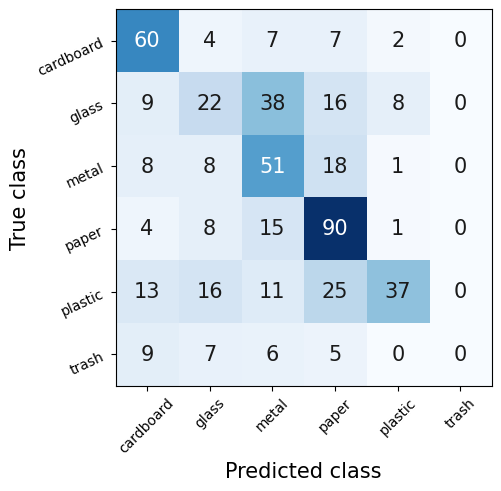

In [ ]:
cmt1 = confusion_matrix_test(model, dl_test, runs, criterion, label )
cmt1.plot(cmap=plt.cm.Blues, add_text = True, labels = label )


We will use another model to adress class imbalance.

In [36]:
class TrashMobileNet(nn.Module, PyTorchModelHubMixin):
    def __init__(self, num_classes=6):
        super(TrashMobileNet, self).__init__()
        self.model = mobilenet_v3_large(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        num_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(num_features, num_classes)
        for param in self.model.classifier[-1].parameters():
            param.requires_grad = True
    def forward(self, x):
        x = self.model(x)
        return x

In [39]:
if wandb.run is not None:
    wandb.finish()

runs = wandb.init(
    project="trash-classification-logger",
    name="Trashmobilenet-1-model-pradana",
    id="trashnet-9999-pradana",
    config={
    "learning_rate": 0.001,
    "architecture": "Trashmobilenet-1",
    "dataset": "garythung/trashnet",
    "epochs": 5,
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "early_stopping_patience":3,
    "train_batch_size":64,
    "val_batch_size":32,
    "test_batch_size":32,
    "num_workers":2,
    "num_classes":len(label),
    "optimizer":"Adam",
    "model_name":"Trashmobilenet-v1"
    },
    settings=wandb.Settings(init_timeout=120),
    reinit=True
)


wandb: Currently logged in as: pradanaadn (pradanaadn-pradanaadn). Use `wandb login --relogin` to force relogin


In [40]:
model_init = TrashMobileNet().to(runs.config.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_init.parameters(), lr=runs.config.learning_rate)

In [42]:
summary(model_init, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [44]:
dl_train = torch.utils.data.DataLoader(data_train_transform,
                                       batch_size=runs.config.train_batch_size,
                                       num_workers=runs.config.num_workers,
                                       shuffle = True)
dl_val = torch.utils.data.DataLoader(data_val_transform,
                                     batch_size=runs.config.val_batch_size,
                                     num_workers=runs.config.num_workers)
dl_test = torch.utils.data.DataLoader(data_test_transform, batch_size=runs.config.test_batch_size,
                                      num_workers=runs.config.num_workers)

In [45]:
model = training_loop(model_init, criterion, optimizer, dl_train, dl_val, dl_test, runs)

100%|██████████| 16/16 [01:05<00:00,  4.10s/batch, val_loss=0.827]
2024-12-21 14:35:36.587 | INFO     | __main__:training_loop:83 - {'loss': 0.9429216384887695, 'val_loss': 0.8270010948181152, 'epochs': 1, 'train_accuracy_macro': 0.6277150511741638, 'train_precision_macro': 0.6452593803405762, 'train_recall_macro': 0.6277150511741638, 'train_f1_macro': 0.6310569047927856, 'train_accuracy_micro': 0.6866188645362854, 'train_precision_micro': 0.6866188645362854, 'train_recall_micro': 0.6866188645362854, 'train_f1_micro': 0.6866188645362854, 'train_accuracy_weighted': 0.6866189241409302, 'train_precision_weighted': 0.6789562106132507, 'train_recall_weighted': 0.6866189241409302, 'train_f1_weighted': 0.6809147000312805, 'val_accuracy_macro': 0.6771052479743958, 'val_precision_macro': 0.6870269775390625, 'val_recall_macro': 0.6771052479743958, 'val_f1_macro': 0.6658000349998474, 'val_accuracy_micro': 0.699009895324707, 'val_precision_micro': 0.699009895324707, 'val_recall_micro': 0.699009895

model.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

2024-12-21 14:35:39.335 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.6658000349998474 
100%|██████████| 16/16 [01:05<00:00,  4.11s/batch, val_loss=0.755]
2024-12-21 14:44:44.182 | INFO     | __main__:training_loop:83 - {'loss': 0.5524197816848755, 'val_loss': 0.7553985714912415, 'epochs': 2, 'train_accuracy_macro': 0.7836195230484009, 'train_precision_macro': 0.813464879989624, 'train_recall_macro': 0.7836195230484009, 'train_f1_macro': 0.7943341135978699, 'train_accuracy_micro': 0.8251298666000366, 'train_precision_micro': 0.8251298666000366, 'train_recall_micro': 0.8251298666000366, 'train_f1_micro': 0.8251298666000366, 'train_accuracy_weighted': 0.8251298666000366, 'train_precision_weighted': 0.8231756687164307, 'train_recall_weighted': 0.8251298666000366, 'train_f1_weighted': 0.8223735094070435, 'val_accuracy_macro': 0.6950538754463196, 'val_precision_macro': 0.6909712553024292, 'val_recall_macro': 0.6950538754463196, 'val_f1_macro': 0.

model.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

2024-12-21 14:44:46.391 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.6700868606567383 
100%|██████████| 16/16 [01:05<00:00,  4.10s/batch, val_loss=0.623]
2024-12-21 14:53:49.421 | INFO     | __main__:training_loop:83 - {'loss': 0.46706703305244446, 'val_loss': 0.6233714818954468, 'epochs': 3, 'train_accuracy_macro': 0.8189521431922913, 'train_precision_macro': 0.8457756042480469, 'train_recall_macro': 0.8189521431922913, 'train_f1_macro': 0.8294389247894287, 'train_accuracy_micro': 0.852090060710907, 'train_precision_micro': 0.852090060710907, 'train_recall_micro': 0.852090060710907, 'train_f1_micro': 0.852090060710907, 'train_accuracy_weighted': 0.8520900011062622, 'train_precision_weighted': 0.8511995077133179, 'train_recall_weighted': 0.8520900011062622, 'train_f1_weighted': 0.8504862785339355, 'val_accuracy_macro': 0.7795906662940979, 'val_precision_macro': 0.7613914608955383, 'val_recall_macro': 0.7795906662940979, 'val_f1_macro': 0.75

model.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

2024-12-21 14:53:52.347 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.759605884552002 
100%|██████████| 16/16 [01:05<00:00,  4.08s/batch, val_loss=0.51]
2024-12-21 15:02:47.064 | INFO     | __main__:training_loop:83 - {'loss': 0.4083172082901001, 'val_loss': 0.509741485118866, 'epochs': 4, 'train_accuracy_macro': 0.8365897536277771, 'train_precision_macro': 0.8602377772331238, 'train_recall_macro': 0.8365897536277771, 'train_f1_macro': 0.8461508750915527, 'train_accuracy_micro': 0.8684145212173462, 'train_precision_micro': 0.8684145212173462, 'train_recall_micro': 0.8684145212173462, 'train_f1_micro': 0.8684145212173462, 'train_accuracy_weighted': 0.868414580821991, 'train_precision_weighted': 0.8674784898757935, 'train_recall_weighted': 0.868414580821991, 'train_f1_weighted': 0.8670206069946289, 'val_accuracy_macro': 0.7983697652816772, 'val_precision_macro': 0.789238452911377, 'val_recall_macro': 0.7983697652816772, 'val_f1_macro': 0.78950

model.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

2024-12-21 15:02:49.828 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.7895099520683289 
100%|██████████| 16/16 [01:03<00:00,  3.95s/batch, val_loss=0.435]
2024-12-21 15:11:45.217 | INFO     | __main__:training_loop:83 - {'loss': 0.37191396951675415, 'val_loss': 0.43519410490989685, 'epochs': 5, 'train_accuracy_macro': 0.853421688079834, 'train_precision_macro': 0.8747075200080872, 'train_recall_macro': 0.853421688079834, 'train_f1_macro': 0.8624340891838074, 'train_accuracy_micro': 0.8807815909385681, 'train_precision_micro': 0.8807815909385681, 'train_recall_micro': 0.8807815909385681, 'train_f1_micro': 0.8807815909385681, 'train_accuracy_weighted': 0.8807816505432129, 'train_precision_weighted': 0.8802893161773682, 'train_recall_weighted': 0.8807816505432129, 'train_f1_weighted': 0.8798664808273315, 'val_accuracy_macro': 0.8416836857795715, 'val_precision_macro': 0.8322639465332031, 'val_recall_macro': 0.8416836857795715, 'val_f1_macro': 0

model.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

2024-12-21 15:11:48.438 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.834179699420929 
100%|██████████| 16/16 [01:03<00:00,  3.95s/batch, val_loss=0.387]
2024-12-21 15:20:42.604 | INFO     | __main__:training_loop:83 - {'loss': 0.3432481288909912, 'val_loss': 0.38720908761024475, 'epochs': 6, 'train_accuracy_macro': 0.8711602091789246, 'train_precision_macro': 0.8906617164611816, 'train_recall_macro': 0.8711602091789246, 'train_f1_macro': 0.8795323371887207, 'train_accuracy_micro': 0.8948800563812256, 'train_precision_micro': 0.8948800563812256, 'train_recall_micro': 0.8948800563812256, 'train_f1_micro': 0.8948800563812256, 'train_accuracy_weighted': 0.8948800563812256, 'train_precision_weighted': 0.8947336673736572, 'train_recall_weighted': 0.8948800563812256, 'train_f1_weighted': 0.8941835761070251, 'val_accuracy_macro': 0.851706862449646, 'val_precision_macro': 0.8415852785110474, 'val_recall_macro': 0.851706862449646, 'val_f1_macro': 0.8

model.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

2024-12-21 15:20:45.372 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.8442572355270386 
100%|██████████| 16/16 [01:02<00:00,  3.90s/batch, val_loss=0.369]
2024-12-21 15:29:59.469 | INFO     | __main__:training_loop:83 - {'loss': 0.3348688781261444, 'val_loss': 0.3690759837627411, 'epochs': 7, 'train_accuracy_macro': 0.8689236640930176, 'train_precision_macro': 0.8789209723472595, 'train_recall_macro': 0.8689236640930176, 'train_f1_macro': 0.8735495805740356, 'train_accuracy_micro': 0.8894385099411011, 'train_precision_micro': 0.8894385099411011, 'train_recall_micro': 0.8894385099411011, 'train_f1_micro': 0.8894385099411011, 'train_accuracy_weighted': 0.8894385099411011, 'train_precision_weighted': 0.8888495564460754, 'train_recall_weighted': 0.8894385099411011, 'train_f1_weighted': 0.8889166712760925, 'val_accuracy_macro': 0.8729087710380554, 'val_precision_macro': 0.8577479124069214, 'val_recall_macro': 0.8729087710380554, 'val_f1_macro': 0

model.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

2024-12-21 15:30:03.424 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.8628233075141907 
100%|██████████| 16/16 [01:03<00:00,  3.97s/batch, val_loss=0.353]
2024-12-21 15:39:09.643 | INFO     | __main__:training_loop:83 - {'loss': 0.3203568756580353, 'val_loss': 0.35250964760780334, 'epochs': 8, 'train_accuracy_macro': 0.8870559930801392, 'train_precision_macro': 0.8917095065116882, 'train_recall_macro': 0.8870559930801392, 'train_f1_macro': 0.8892362713813782, 'train_accuracy_micro': 0.8990848660469055, 'train_precision_micro': 0.8990848660469055, 'train_recall_micro': 0.8990848660469055, 'train_f1_micro': 0.8990848660469055, 'train_accuracy_weighted': 0.8990848064422607, 'train_precision_weighted': 0.8989419937133789, 'train_recall_weighted': 0.8990848064422607, 'train_f1_weighted': 0.898880660533905, 'val_accuracy_macro': 0.8734250068664551, 'val_precision_macro': 0.8654140830039978, 'val_recall_macro': 0.8734250068664551, 'val_f1_macro': 0

model.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

2024-12-21 15:39:14.402 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.8682499527931213 
100%|██████████| 16/16 [01:01<00:00,  3.87s/batch, val_loss=0.345]
2024-12-21 15:48:12.224 | INFO     | __main__:training_loop:83 - {'loss': 0.29578977823257446, 'val_loss': 0.34481748938560486, 'epochs': 9, 'train_accuracy_macro': 0.8940696716308594, 'train_precision_macro': 0.9009925127029419, 'train_recall_macro': 0.8940696716308594, 'train_f1_macro': 0.8973329663276672, 'train_accuracy_micro': 0.9065050482749939, 'train_precision_micro': 0.9065050482749939, 'train_recall_micro': 0.9065050482749939, 'train_f1_micro': 0.9065050482749939, 'train_accuracy_weighted': 0.9065051078796387, 'train_precision_weighted': 0.9065049886703491, 'train_recall_weighted': 0.9065051078796387, 'train_f1_weighted': 0.9063399434089661, 'val_accuracy_macro': 0.8690612316131592, 'val_precision_macro': 0.8576797246932983, 'val_recall_macro': 0.8690612316131592, 'val_f1_macro':

model.safetensors:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

2024-12-21 15:57:15.826 | SUCCESS  | __main__:save_checkpoint:43 - Success Saving best model with F1-Score Macro 0.8718867301940918 
<ipython-input-23-70a290489a46>:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issu

100%|██████████| 16/16 [01:02<00:00,  3.92s/batch]


Confusion Matrix:
 [[ 75   0   0   4   0   1]
 [  0  81   3   0   8   1]
 [  0   6  76   3   1   0]
 [  1   0   0 110   2   5]
 [  0   6   5   2  87   2]
 [  2   0   0   3   3  19]]


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

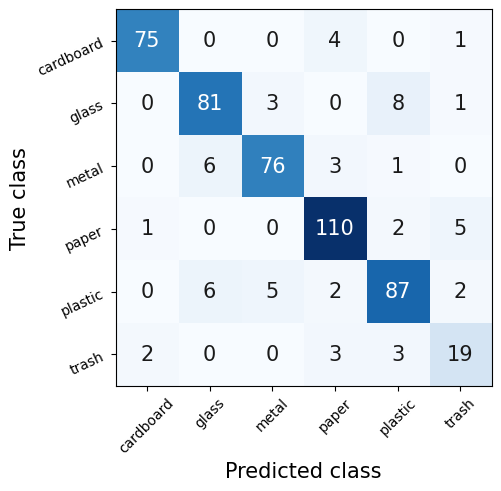

In [46]:
cmt2 = confusion_matrix_test(model, dl_test, runs, criterion, label )
cmt2.plot(cmap=plt.cm.Blues, add_text = True, labels = label )
